# Lab | Sakila logistic regression model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task" data-toc-modified-id="Task-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task</a></span></li><li><span><a href="#Importing-libraries" data-toc-modified-id="Importing-libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing libraries</a></span></li><li><span><a href="#Importing-Data-from-SQL" data-toc-modified-id="Importing-Data-from-SQL-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Importing Data from SQL</a></span></li><li><span><a href="#Preparing-the-data-for-the-model" data-toc-modified-id="Preparing-the-data-for-the-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preparing the data for the model</a></span><ul class="toc-item"><li><span><a href="#Exploration" data-toc-modified-id="Exploration-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Exploration</a></span></li><li><span><a href="#Cleaning" data-toc-modified-id="Cleaning-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Cleaning</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Encoding-categorical-data" data-toc-modified-id="Encoding-categorical-data-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Encoding categorical data</a></span></li></ul></li><li><span><a href="#Target-variable" data-toc-modified-id="Target-variable-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Target variable</a></span><ul class="toc-item"><li><span><a href="#Importing-data" data-toc-modified-id="Importing-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Importing data</a></span></li><li><span><a href="#Preparing-data-for-model" data-toc-modified-id="Preparing-data-for-model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Preparing data for model</a></span></li></ul></li><li><span><a href="#Logistic-regression-model" data-toc-modified-id="Logistic-regression-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Logistic regression model</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Task
In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

## Importing libraries

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
password = getpass.getpass()

 ···············


## Importing Data from SQL

Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''
        SELECT f.film_id, c.name AS category, release_year, language_id, rental_duration, rental_rate, length, replacement_cost, rating
        FROM film f
        JOIN film_category fc
        ON fc.film_id = f.film_id
        JOIN category c
        ON c.category_id = fc.category_id;
        '''

Read the data into a Pandas dataframe.


In [3]:
data = pd.read_sql_query(query, engine)
data

,film_id,category,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating
0,19,Action,2006,1,6,0.99,113,20.99,PG
1,21,Action,2006,1,3,4.99,129,17.99,R
2,29,Action,2006,1,5,2.99,168,11.99,NC-17
3,38,Action,2006,1,6,0.99,68,25.99,NC-17
4,56,Action,2006,1,6,2.99,129,15.99,G
...,...,...,...,...,...,...,...,...,...
995,931,Travel,2006,1,7,0.99,48,9.99,PG-13
996,977,Travel,2006,1,3,2.99,85,25.99,R
997,981,Travel,2006,1,7,0.99,55,13.99,NC-17
998,988,Travel,2006,1,7,2.99,139,26.99,R


In [4]:
query_2 = '''
            WITH cte AS
                        (SELECT i.film_id, COUNT(rental_id) AS count_rented_total
                        FROM rental r
                        JOIN inventory i
                        USING (inventory_id)
                        GROUP BY i.film_id)
            SELECT f.film_id, c.name, release_year, language_id, rental_duration, rental_rate, length, replacement_cost, rating, count_rented_total
            FROM film f
            JOIN film_category fc
            ON fc.film_id = f.film_id
            JOIN category c
            ON c.category_id = fc.category_id
            LEFT JOIN cte
            ON cte.film_id = f.film_id
            ORDER BY count_rented DESC;
        '''

**Difficulties with more complex SQL-query:**
- my second query with the cte doesn't run via Python although it does in SQL-Workbench
- created a view instead to upload it as a table from Workbench directly

In [5]:
data = pd.read_sql_table('data_logistic_regression', engine)
data

,film_id,name,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating,count_rented_total
0,19,Action,2006,1,6,0.99,113,20.99,PG,21.0
1,21,Action,2006,1,3,4.99,129,17.99,R,22.0
2,29,Action,2006,1,5,2.99,168,11.99,NC-17,10.0
3,38,Action,2006,1,6,0.99,68,25.99,NC-17,NaN
4,56,Action,2006,1,6,2.99,129,15.99,G,18.0
...,...,...,...,...,...,...,...,...,...,...
995,931,Travel,2006,1,7,0.99,48,9.99,PG-13,12.0
996,977,Travel,2006,1,3,2.99,85,25.99,R,12.0
997,981,Travel,2006,1,7,0.99,55,13.99,NC-17,21.0
998,988,Travel,2006,1,7,2.99,139,26.99,R,15.0


## Preparing the data for the model

Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.


### Exploration

In [6]:
data.shape

(1000, 10)

In [7]:
data.dtypes

film_id                 int64
name                   object
release_year            int64
language_id             int64
rental_duration         int64
rental_rate           float64
length                  int64
replacement_cost      float64
rating                 object
count_rented_total    float64
dtype: object

In [8]:
data.describe()

,film_id,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,count_rented_total
count,1000.000000,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,958.000000
mean,500.500000,2006.0,1.0,4.985000,2.980000,115.272000,19.984000,16.747390
std,288.819436,0.0,0.0,1.411654,1.646393,40.426332,6.050833,6.676185
min,1.000000,2006.0,1.0,3.000000,0.990000,46.000000,9.990000,4.000000
25%,250.750000,2006.0,1.0,4.000000,0.990000,80.000000,14.990000,11.000000
50%,500.500000,2006.0,1.0,5.000000,2.990000,114.000000,19.990000,16.000000
75%,750.250000,2006.0,1.0,6.000000,4.990000,149.250000,24.990000,22.000000
max,1000.000000,2006.0,1.0,7.000000,4.990000,185.000000,29.990000,34.000000


--> language_id and release_year seem to be the same for all columns; these can be dropped after checking if this is true!

In [9]:
data.isna().sum()

film_id                0
name                   0
release_year           0
language_id            0
rental_duration        0
rental_rate            0
length                 0
replacement_cost       0
rating                 0
count_rented_total    42
dtype: int64

### Cleaning

**Setting film_id as index:**

In [10]:
data = data.set_index('film_id')
data

,name,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating,count_rented_total
film_id,,,,,,,,,
19,Action,2006,1,6,0.99,113,20.99,PG,21.0
21,Action,2006,1,3,4.99,129,17.99,R,22.0
29,Action,2006,1,5,2.99,168,11.99,NC-17,10.0
38,Action,2006,1,6,0.99,68,25.99,NC-17,NaN
56,Action,2006,1,6,2.99,129,15.99,G,18.0
...,...,...,...,...,...,...,...,...,...
931,Travel,2006,1,7,0.99,48,9.99,PG-13,12.0
977,Travel,2006,1,3,2.99,85,25.99,R,12.0
981,Travel,2006,1,7,0.99,55,13.99,NC-17,21.0


**Replacing NaN-values in column count_rented_total with 0:** <br>
reason: NaN = film wasn't rented at all

In [11]:
data = data.fillna(0)

In [12]:
data.isna().sum()

name                  0
release_year          0
language_id           0
rental_duration       0
rental_rate           0
length                0
replacement_cost      0
rating                0
count_rented_total    0
dtype: int64

Checking unique values for numeric columns:

In [13]:
for col in data.select_dtypes(np.number):
    print(data[col].value_counts(), '\n')

2006    1000
Name: release_year, dtype: int64 

1    1000
Name: language_id, dtype: int64 

6    212
3    203
4    203
5    191
7    191
Name: rental_duration, dtype: int64 

0.99    341
4.99    336
2.99    323
Name: rental_rate, dtype: int64 

85     17
179    13
112    13
84     13
100    12
       ..
81      3
95      2
66      2
55      2
96      2
Name: length, Length: 140, dtype: int64 

20.99    57
12.99    55
21.99    55
13.99    55
22.99    55
27.99    53
29.99    53
14.99    51
19.99    50
10.99    49
11.99    49
17.99    47
26.99    46
23.99    45
25.99    43
18.99    42
28.99    41
9.99     41
16.99    38
24.99    38
15.99    37
Name: replacement_cost, dtype: int64 

16.0    54
21.0    52
13.0    52
15.0    51
17.0    49
14.0    47
19.0    45
9.0     44
20.0    43
18.0    43
0.0     42
22.0    39
11.0    39
7.0     38
10.0    38
23.0    36
8.0     36
12.0    36
24.0    33
6.0     31
25.0    27
27.0    26
26.0    24
30.0    16
29.0    15
5.0     14
28.0    11
31.0     9
32.0

Actions to be taken:
- removing columns realease_year and language_id as all rows contain the same value
- using columns rental_duration and rental_rate as categorical columns as there is just a very limited set of unique values

**Dropping unnecessary columns:**

In [14]:
data = data.drop(['release_year', 'language_id'], axis=1)

**Changing column types:**

In [15]:
data['rental_duration'] = data['rental_duration'].astype('object')
data['rental_rate'] = data['rental_rate'].astype('object')

### EDA

**Checking out correlation matrix:**

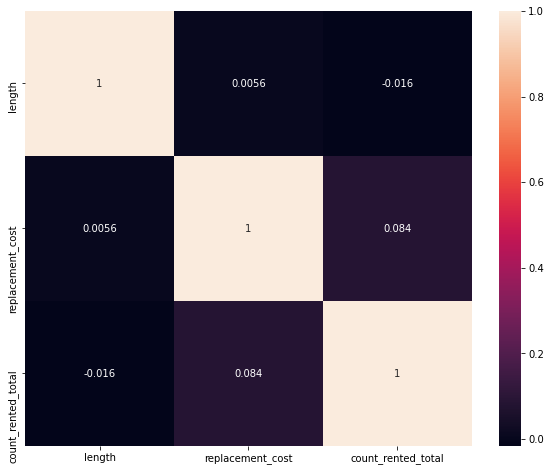

In [16]:
corr_matrix=data.corr()
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

--> no high correlation, no need to drop any columns

**Checking out distribution of numerical columns:**

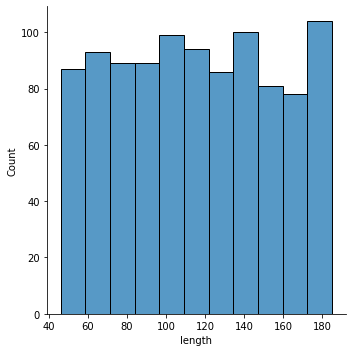

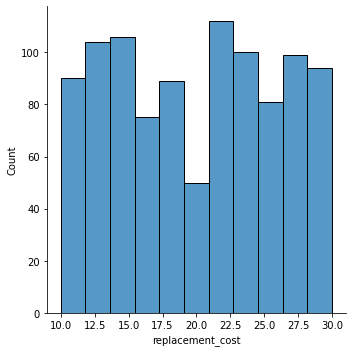

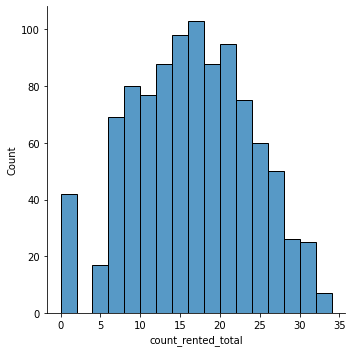

In [17]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

### Encoding categorical data

Checking unique values for categorical columns:

In [18]:
for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

Sports         74
Foreign        73
Family         69
Documentary    68
Animation      66
Action         64
New            63
Drama          62
Games          61
Sci-Fi         61
Children       60
Comedy         58
Classics       57
Travel         57
Horror         56
Music          51
Name: name, dtype: int64 

6    212
3    203
4    203
5    191
7    191
Name: rental_duration, dtype: int64 

0.99    341
4.99    336
2.99    323
Name: rental_rate, dtype: int64 

PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64 



**Creating copy of data frame:**

In [19]:
X = data
X

,name,rental_duration,rental_rate,length,replacement_cost,rating,count_rented_total
film_id,,,,,,,
19,Action,6,0.99,113,20.99,PG,21.0
21,Action,3,4.99,129,17.99,R,22.0
29,Action,5,2.99,168,11.99,NC-17,10.0
38,Action,6,0.99,68,25.99,NC-17,0.0
56,Action,6,2.99,129,15.99,G,18.0
...,...,...,...,...,...,...,...
931,Travel,7,0.99,48,9.99,PG-13,12.0
977,Travel,3,2.99,85,25.99,R,12.0
981,Travel,7,0.99,55,13.99,NC-17,21.0


In [20]:
X = pd.get_dummies(X)
X

,length,replacement_cost,count_rented_total,name_Action,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,...,rental_duration_6,rental_duration_7,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
film_id,,,,,,,,,,,,,,,,,,,,,
19,113,20.99,21.0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
21,129,17.99,22.0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
29,168,11.99,10.0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
38,68,25.99,0.0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
56,129,15.99,18.0,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,48,9.99,12.0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
977,85,25.99,12.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
981,55,13.99,21.0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0


## Target variable

Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

### Importing data

In [21]:
query_rented = '''
        WITH cte1 AS
                    (SELECT DATE_FORMAT(CONVERT(r.rental_date, DATE), '%Y-%m') AS new_rental_date,
                            i.film_id
                    FROM rental r
                    JOIN inventory i
                    USING (inventory_id)
                    GROUP BY 1,2),
        cte2 AS
                (SELECT new_rental_date,
                        film_id,
                        RANK() OVER(PARTITION BY film_id ORDER BY new_rental_date DESC) AS ranking
                FROM cte1),
        cte3 AS
                (SELECT *
                FROM cte2
                WHERE ranking = 1
                AND new_rental_date = (SELECT MAX(new_rental_date) AS last_month FROM cte1))
        SELECT f.film_id, c.new_rental_date
        FROM film f
        LEFT JOIN cte3 c
        USING (film_id);
        '''

**Again difficulties with SQL-query:**
- my query with three ctes doesn't run via Python although it does in SQL-Workbench
- created a view instead to upload it as a table from Workbench directly

In [22]:
y = pd.read_sql_table('target_logistic_regression', engine)
y

,film_id,new_rental_date
0,1,None
1,2,2006-02
2,3,None
3,4,2006-02
4,5,2006-02
...,...,...
995,996,None
996,997,None
997,998,2006-02
998,999,None


### Preparing data for model

**Setting film_id as index:**

In [23]:
y = y.set_index('film_id')
y

,new_rental_date
film_id,
1,None
2,2006-02
3,None
4,2006-02
5,2006-02
...,...
996,None
997,None
998,2006-02


In [24]:
y.isna().sum()

new_rental_date    832
dtype: int64

**Replacing "None" with O:**

In [39]:
y = y.fillna(0)

**Replacing '2006-02' with 1:**

In [38]:
y = y.replace('2006-02', 1)

**Changing column name:**

In [27]:
y = y.rename(columns = {'new_rental_date':'rented_last_month'})
y

,rented_last_month
film_id,
1,0
2,1
3,0
4,1
5,1
...,...
996,0
997,0
998,1


**ALTERNATIVE to manual steps** <br>
- creating a function to fill in 1 or 0
    - 1 = film was rented last month
    - 0 = film was not rented last month
- unfortunately this function did not work.. why?
- error code: "ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all()"

In [28]:
def showing_rented(x):
    if x == None:
        return 0
    else:
        return 1
    
y.apply(showing_rented)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Logistic regression model

Create a logistic regression model to predict this variable from the cleaned data.


**Train-test-split:**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [31]:
classification = LogisticRegression(random_state=42, max_iter=500) 
classification.fit(X_train, y_train)

c:\users\katha\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(max_iter=500, random_state=42)

## Results

Evaluate the results (calculate the score of the model).

In [32]:
classification.score(X_test, y_test)

0.825

In [33]:
predictions = classification.predict(X_test)

pd.Series(predictions).value_counts()

0    200
dtype: int64

In [34]:
y_test.value_counts()

rented_last_month
0                    165
1                     35
dtype: int64

**Confusion matrix:**

In [35]:
confusion_matrix(y_test, predictions)

array([[165,   0],
       [ 35,   0]], dtype=int64)

<AxesSubplot:>

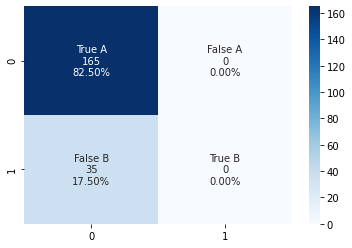

In [37]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True A', 'False A',
               'False B', 'True B']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## Conclusion

**1. How good are my predictions?**

The predictions seem fine at first, when looking at an accuracy score of 82,5%. However after checking the confusion matrix we can see that the model predicts that the film won't be rented in 100% of the cases and is right in 82,5% of the cases. The predictions therefore do not help at all.

**2. What am I actually predicting here? What do I want to achieve with these predictions?**

I am predicting if a specific film is going to be rented in the next month or not. We want to improve the inventory of the rental company. Films which are not likely to be rented need less copies - for films which will most likely be rented the company might get more copies.

**3. Have I chosen my data wisely? (garbage in - garbage out)**

No, too much imbalance in the dataset.

**4. Thoughts on how to improve the model?**

The dataset is pretty small which makes it difficult for the model to train - a larger dataset would help to improve the model. Secondly, the data currently is very imbalanced and would need to be balanced out to improve the model.